In [39]:
#!pip install pyhessian
#!pip install pytorchcv

import torch
import torchvision
import torchvision.transforms as transforms

from pyhessian import hessian
import numpy as np

from pytorchcv.model_provider import get_model as ptcv_get_model # model

import matplotlib.pyplot as plt
#%matplotlib inline 

In [40]:
# enable cuda devices
import os    
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [41]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable


def getData(name='cifar10', train_bs=128, test_bs=1000):
    """
    Get the dataloader
    """
    if name == 'cifar10':
        transform_train = transforms.Compose([
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize((0.4914, 0.4822, 0.4465),
                                 (0.2023, 0.1994, 0.2010)),
        ])

        transform_test = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.4914, 0.4822, 0.4465),
                                 (0.2023, 0.1994, 0.2010)),
        ])

        trainset = datasets.CIFAR10(root='../data',
                                    train=True,
                                    download=True,
                                    transform=transform_train)
        train_loader = torch.utils.data.DataLoader(trainset,
                                                   batch_size=train_bs,
                                                   shuffle=True)

        testset = datasets.CIFAR10(root='../data',
                                   train=False,
                                   download=False,
                                   transform=transform_test)
        test_loader = torch.utils.data.DataLoader(testset,
                                                  batch_size=test_bs,
                                                  shuffle=False)
    if name == 'cifar10_without_dataaugmentation':
        transform_train = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.4914, 0.4822, 0.4465),
                                 (0.2023, 0.1994, 0.2010)),
        ])

        transform_test = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.4914, 0.4822, 0.4465),
                                 (0.2023, 0.1994, 0.2010)),
        ])

        trainset = datasets.CIFAR10(root='../data',
                                    train=True,
                                    download=True,
                                    transform=transform_train)
        train_loader = torch.utils.data.DataLoader(trainset,
                                                   batch_size=train_bs,
                                                   shuffle=True)

        testset = datasets.CIFAR10(root='../data',
                                   train=False,
                                   download=False,
                                   transform=transform_test)
        test_loader = torch.utils.data.DataLoader(testset,
                                                  batch_size=test_bs,
                                                  shuffle=False)

    return train_loader, test_loader


def test(model, test_loader, cuda=True):
    """
    Get the test performance
    """
    model.eval()
    correct = 0
    total_num = 0
    for data, target in test_loader:
        if cuda:
            data, target = data.cuda(), target.cuda()
        output = model(data)
        pred = output.data.max(
            1, keepdim=True)[1]  # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum().item()
        total_num += len(data)
    print('testing_correct: ', correct / total_num, '\n')
    return correct / total_num

In [49]:
# get the model 
model = ptcv_get_model("resnet20_cifar10", pretrained=True)
# change the model to eval mode to disable running stats upate
model.eval()

# create loss function
criterion = torch.nn.CrossEntropyLoss()

# get dataset 
train_loader, test_loader = getData()

# for illustrate, we only use one batch to do the tutorial
for inputs, targets in train_loader:
    break

# we use cuda to make the computation fast
model = model.cuda()
inputs, targets = inputs.cuda(), targets.cuda()

Files already downloaded and verified


In [50]:
hessian_comp = hessian(model, criterion, data=(inputs, targets), cuda=True)

# get the top eigenvector
top_eigenvalues, top_eigenvector = hessian_comp.eigenvalues(top_n=2)

In [44]:
# This is a simple function, that will allow us to perturb the model paramters and get the result
def get_params(model_orig,  model_perb, direction, alpha):
    for m_orig, m_perb, d in zip(model_orig.parameters(), model_perb.parameters(), direction):
        m_perb.data = m_orig.data + alpha * d
    return model_perb

C:\Users\JM\anaconda3\envs\maml\lib\site-packages\ipykernel_launcher.py:26: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().


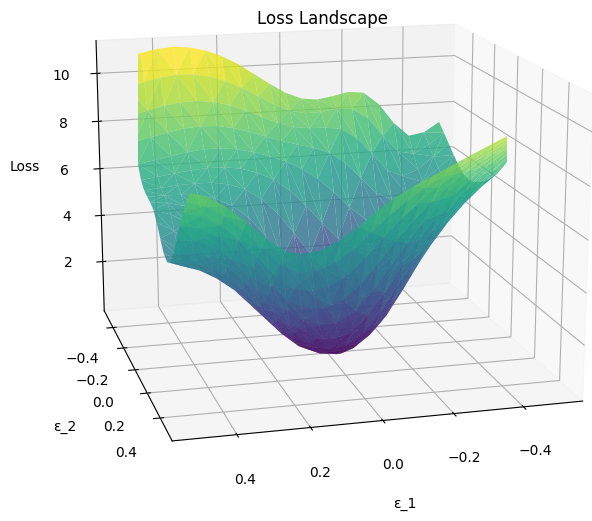

In [54]:
# lambda is a small scalar that we use to perturb the model parameters along the eigenvectors 
lams1 = np.linspace(-0.5, 0.5, 21).astype(np.float32)
lams2 = np.linspace(-0.5, 0.5, 21).astype(np.float32)

loss_list = []

# create a copy of the model
model_perb1 = ptcv_get_model("resnet20_cifar10", pretrained=True)
model_perb1.eval()
model_perb1 = model_perb1.cuda()

model_perb2 = ptcv_get_model("resnet20_cifar10", pretrained=True)
model_perb2.eval()
model_perb2 = model_perb2.cuda()


for lam1 in lams1:
    for lam2 in lams2:
        model_perb1 = get_params(model, model_perb1, top_eigenvector[0], lam1)
        model_perb2 = get_params(model_perb1, model_perb2, top_eigenvector[1], lam2)
        loss_list.append((lam1, lam2, criterion(model_perb2(inputs), targets).item()))   

loss_list = np.array(loss_list)
                         
fig = plt.figure()
landscape = fig.gca(projection='3d')
landscape.plot_trisurf(loss_list[:,0], loss_list[:,1], loss_list[:,2],alpha=0.8, cmap='viridis')
                       #cmap=cm.autumn, #cmamp = 'hot')


landscape.set_title('Loss Landscape')
landscape.set_xlabel('ε_1')
landscape.set_ylabel('ε_2')
landscape.set_zlabel('Loss')

landscape.view_init(elev=15, azim=75)
landscape.dist = 6
plt.show()